# Attempt to Model Velocity Dependence _with DNNs_
Retry the problem form the previous notebook

In [1]:
%matplotlib inline
import os
import sys
# Add the directory containing your module to the Python path
sys.path.append(os.path.abspath('/scratch/users/pdanie20/silicon/PD-stopping-power-ml'))

from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.keras import build_fn as build_dense
from glob import glob
from tqdm import tqdm_notebook as tqdm

from keras.layers import Dense, Activation, Input
from keras.layers import Concatenate, Multiply, Add
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import pickle as pkl
import numpy as np
import pandas as pd


2024-10-10 15:34:57.350252: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 15:34:57.351024: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 15:34:58.314028: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 15:34:59.311058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-10-10 15:35:10.659098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load in Data
Read in the random trajectories

In [2]:
channel_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'channel_traj.pkl'))
random_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))
#data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))


In [3]:
with open(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'featurizer.pkl'), 'rb') as fp:
    featurizer = pkl.load(fp)

x_labels = list(featurizer.feature_labels())

In [4]:
x = pd.concat([channel_data[x_labels], random_data[x_labels]], sort=False)
y = pd.concat([channel_data['force'], random_data['force']], sort=False)
x.shape

(150039, 19)

## Split the data into training, validation, and testing categotries 

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(105027, 19) (105027,)
(22506, 19) (22506,)
(22506, 19) (22506,)


## Create Functions for Building Models
Create functions for building a Keras model

In [6]:
input_shape = (len(x_labels),)
layers = (input_shape[0],64,48,32,16,8,3)
#(input_shape[0],32,24,8,4,3)
activation = 'elu'
regularizerr = regularizers.L2(5e-3)

In [7]:

optimizer_options = {
    'loss': 'mean_absolute_error', 
    'optimizer': Adam(learning_rate=0.00005),
    'metrics': ['mean_absolute_error']
}

2024-10-10 15:35:36.739177: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-10 15:35:36.739250: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: ccc0422.campuscluster.illinois.edu
2024-10-10 15:35:36.739260: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: ccc0422.campuscluster.illinois.edu
2024-10-10 15:35:36.739392: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.90.7
2024-10-10 15:35:36.739433: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  550.90.07  Release Build  (dvs-builder@U16-I2-C05-15-3)  Fri May 31 09:44:37 UTC 2024
GCC ve

In [8]:
callbacks = [EarlyStopping(monitor='mean_absolute_error', patience=100, verbose=0, mode='auto'),
             ReduceLROnPlateau('mean_absolute_error')]

### Standard Dense Model
Just treat all layers equally

In [9]:
# model = build_dense(len(X_cols), layers, activation=activation, use_linear_block=False,
#                    optimizer_options=optimizer_options,regularizer=regularizerr, )

model = build_dense(len(x_labels), layers, activation=activation, use_linear_block=False, 
                   optimizer_options=optimizer_options,regularizer=regularizerr,use_regularizer=False)



In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 19)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 19)                  │             380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 48)                  │           3,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,043 (27.51 KB)

 Trainable params: 7,043 (27.51 KB)

 Non-trainable params: 0 (0.00 B)

## Test on the Whole Dataset
Fit the model on the whole dataset

In [11]:
# def fit_on_whole_dataset(model, data, callbacks=[], epochs=1, split_v=False):
#     """Train a model on the whole dataset
    
#     Args:
#         model (Model): Model to be trained 
#         callbacks ([List]): List of callbacks used during training
#         epochs (int): Maximum number of epochs for training
#     Returns:
#         history - history from the fit
#     """

#     # Train the model
#     if split_v:
#         return model.fit([data[X_cols_novel], data[X_cols_vel]], data[y_col], epochs=epochs, callbacks=callbacks, verbose=0)
#     else:
#         return model.fit(data[X_cols], data[y_col], epochs=epochs, callbacks=callbacks, verbose=0)

Fit the whole model

In [12]:
%%time
dense_history = model.fit(X_train , y_train , epochs=1000,
                      callbacks=callbacks,
                      validation_data=(X_val, y_val),
                      verbose=0, batch_size=32)

CPU times: user 32min 2s, sys: 1min 1s, total: 33min 3s
Wall time: 27min 32s


Plot results

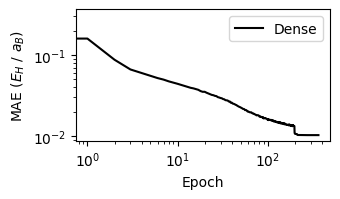

In [13]:
fig, ax = plt.subplots()

ax.loglog(dense_history.epoch, dense_history.history['mean_absolute_error'], 'k', label='Dense')
#ax.loglog(merge_history.epoch, merge_history.history['mean_absolute_error'], 'r', label='Merged')

ax.set_ylabel('MAE ($E_H$ / $a_B$)')
ax.set_xlabel('Epoch')

ax.legend()

fig.set_size_inches(3.5, 2.1)
fig.tight_layout()

## Evaluate Model Performance
Get the performance of the model on the whole dataset

In [14]:
data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))

In [15]:
def plot_performance(model, split_v):
    """Evaluate and plot the performance of the model on multiple velocities
    
    Args:
        model (keras.Model): Model to be trained
        data (pd.Dataframe): Training set
    """

    # Evaluate on the whole dataset
    if split_v:
        data['force_fit'] = model.predict([data[X_cols_novel], data[X_cols_vel]])
    else:
        data['force_fit'] = model.predict(data[x_labels])        

    # Plot results
    fig, axs = plt.subplots(1, 3)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        # Store the velocity
        velocity.append(group['velocity_mag'].mean())
        
        # Plot the performance on a segment of the dataset
        label = 'v={:.1f}'.format(group['velocity_mag'].mean())
        
        for a in axs[:2]:
            my_line, = a.plot(group['displacement'], group['force'], linestyle='--',
                                  label=label)

            a.plot(group['displacement'], group['force_fit'].tolist(), color=my_line.get_color(), lw=3, alpha=0.5)
            
            a.set_xlabel('Displacement (a.u.)')
            a.set_ylabel('Force ($E_H / a_B$)')
        
        # Store the stopping powers
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    axs[2].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    axs[2].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    axs[2].set_ylabel('Stopping Power ($E_H / a_B$)')
    axs[2].set_xlabel('Velocity (au.)')
    #axs[2].set_ylim(0, max(axs[2].get_ylim()))
    #axs[2].set_xlim(0, 4.2)
    axs[2].legend()
    
    fig.set_size_inches(8, 2.5)
    fig.tight_layout()
    
    # Print the MAPE
    stopping_mape = np.abs(np.subtract(stopping_actual, stopping_pred) / stopping_actual).mean()
    print(f'Mean percent error: {stopping_mape * 100:.2f}%')
    
    return fig, axs, data

Plot the dense model

   1/3514 ━━━━━━━━━━━━━━━━━━━━ 11:02 189ms/step

  79/3514 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step   

 158/3514 ━━━━━━━━━━━━━━━━━━━━ 2s 640us/step

 239/3514 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step

 319/3514 ━━━━━━━━━━━━━━━━━━━━ 2s 633us/step

 400/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step

 479/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step

 559/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step

 640/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step

 719/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step

 800/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step

 881/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step

 961/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step

1041/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step

1123/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step

1205/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step

1286/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step

1365/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step

1446/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step

1526/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step

1606/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step

1687/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step

1767/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step

1846/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step

1927/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

2007/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

2088/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

2169/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step

2249/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

2330/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step

2411/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step

2492/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step

2572/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step

2652/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step

2732/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step

2812/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

2892/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

2972/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

3052/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

3132/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

3211/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

3291/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

3372/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

3452/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

3514/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step

3514/3514 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step


Mean percent error: 2.05%


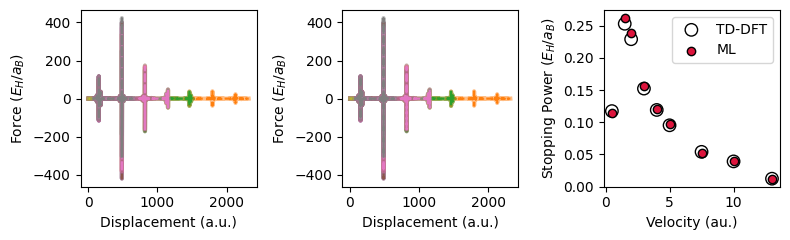

In [16]:
fig, ax, data = plot_performance(model, False)
#data.to_csv(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'fit-random-predict-random.csv'), index=False)

*Finding*: The model does interpolate between different velocities decently. The merged model has better agreement on the stopping powers, but does have some unrealistic wobbles. We might just need to apply some regularization to the model

## Prediction on the Channel Trajectory
Do we capture the behavior that the difference between "channel" and "random" increases with velocity?

In [17]:
%%time
channel_data['force_fit'] = model.predict(channel_data[x_labels])

   1/1176 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step

  81/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step

 161/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step

 241/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step

 322/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

 403/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step

 484/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step

 565/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step

 646/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step

 727/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step

 808/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step

 889/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step

 970/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step

1051/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step

1133/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step

1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step


CPU times: user 1.18 s, sys: 49.9 ms, total: 1.23 s
Wall time: 986 ms


Plot change with velocity

Mean percent error: 3.71%


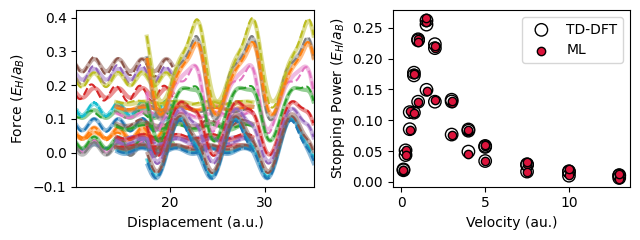

In [18]:
# Plot results
fig, axs = plt.subplots(1, 2)

velocity = []
stopping_pred = []
stopping_actual = []
for gid, group in channel_data.groupby('directory'):
    # Store the velocity
    velocity.append(group['velocity_mag'].mean())

    # Plot the performance on a segment of the dataset
    label = 'v={:.1f}'.format(group['velocity_mag'].mean())

    for a in axs[:1]:
        my_line, = a.plot(group['displacement'], group['force'], linestyle='--',
                              label=label)

        a.plot(group['displacement'], group['force_fit'].tolist(), color=my_line.get_color(), lw=3, alpha=0.5)

        a.set_xlabel('Displacement (a.u.)')
        a.set_ylabel('Force ($E_H / a_B$)')

    # Store the stopping pwoers
    stopping_pred.append(group['force_fit'].mean())
    stopping_actual.append(group['force'].mean())
    
# Clean up the axis ranges
axs[0].set_xlim(channel_data['displacement'].min(), channel_data['displacement'].max())


# Plot the stopping power
axs[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
axs[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')

axs[1].set_ylabel('Stopping Power ($E_H / a_B$)')
axs[1].set_xlabel('Velocity (au.)')
#axs[1].set_ylim(0, max(axs[1].get_ylim()))
#axs[1].set_xlim(0, 4.2)
axs[1].legend()

fig.set_size_inches(6.5, 2.5)
fig.tight_layout()
#fig.savefig(os.path.join('figures', 'train-random-predict-channel.png'), dpi=320)

stopping_mape = np.abs(np.subtract(stopping_actual, stopping_pred) / stopping_actual).mean()
print(f'Mean percent error: {stopping_mape * 100:.2f}%')

*Finding*: We agree well with the stopping powers in the channels, so it seems the model is properly capturing the difference in stopping power as a function of velocity

## Save the Model
For further characterization later

In [19]:
 model.save('model_val_2.h5')

## Save Data
For later plotting purposes

In [20]:
# channel_data.to_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'train_random_predict_channel.pkl.gz'))